In [1]:
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns

In [2]:
# Enforcing GPU usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Loading file paths
train_path = 'D:/DataScience/CMAPSS/Data/train_FD00X.txt'
test_path = 'D:/DataScience/CMAPSS/Data/test_FD00X.txt'
RUL_path = 'D:/DataScience/CMAPSS/Data/RUL_FD00X.txt'
#train_path = f'E:/CMAPSS/data/train_FD00X.txt'
#test_path = f'E:/CMAPSS/data/test_FD00X.txt'
#RUL_path = f'E:/CMAPSS/data/RUL_FD00X.txt'


labels = ['unit', 'cycles', 'opMode1', 'opMode2', 'opMode3'] + [f'sensor{i}' for i in range(1, 22)]  # for 22 sensors


In [4]:
# Function to load data and drop the columns specified by cols_to_drop, and add an RUL column for each unit
def load_data(filepath, rul=False):
    data = []
    # Creating lists which hold dataframes for each test trajectory
    if not rul:
        for i in range(1, 5):
            data.append(pd.read_csv(filepath.replace('X', str(i)),
                                    names=labels, delimiter='\s+',
                                    dtype=np.float32))
        return data
    else:
        for i in range(1, 5):
            data.append(pd.read_csv(filepath.replace('X', str(i)),
                                    delimiter='\s+', header=None,
                                    dtype=np.float32))

        return data  # a list


def prepare_data(train_data: pd.DataFrame):
    # Drops redundant columns and adds an RUL column for training
    
    ### TRAINING DATAFRAMES ###

    rul = pd.DataFrame(train_data.groupby('unit')['cycles'].max()).reset_index()
    rul.columns = ['unit', 'max']

    train_data = train_data.merge(rul, on=['unit'], how='left')

    train_data['RUL'] = train_data['max'] - train_data['cycles']
    train_data.drop('max', axis=1, inplace=True)

    return train_data

In [5]:
# Initialising data
train_data, test_data, RUL_data = load_data(train_path), load_data(test_path), load_data(RUL_path, True)

# Adding RUL columns to the training dataframes dataframe
for i in range(len(train_data)):
    train_data[i] = prepare_data(train_data[i])


In [6]:
train_data[0].head()

,unit,cycles,opMode1,opMode2,opMode3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
0,1.0,1.0,-0.0007,-0.0004,100.0,518.669983,641.820007,1589.699951,1400.599976,14.62,...,2388.020020,8138.620117,8.4195,0.03,392.0,2388.0,100.0,39.060001,23.419001,191.0
1,1.0,2.0,0.0019,-0.0003,100.0,518.669983,642.150024,1591.819946,1403.140015,14.62,...,2388.070068,8131.490234,8.4318,0.03,392.0,2388.0,100.0,39.000000,23.423599,190.0
2,1.0,3.0,-0.0043,0.0003,100.0,518.669983,642.349976,1587.989990,1404.199951,14.62,...,2388.030029,8133.229980,8.4178,0.03,390.0,2388.0,100.0,38.950001,23.344200,189.0
3,1.0,4.0,0.0007,0.0000,100.0,518.669983,642.349976,1582.790039,1401.869995,14.62,...,2388.080078,8133.830078,8.3682,0.03,392.0,2388.0,100.0,38.880001,23.373899,188.0
4,1.0,5.0,-0.0019,-0.0002,100.0,518.669983,642.369995,1582.849976,1406.219971,14.62,...,2388.040039,8133.799805,8.4294,0.03,393.0,2388.0,100.0,38.900002,23.404400,187.0


In [7]:
train_data[0].describe()

,unit,cycles,opMode1,opMode2,opMode3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,...,20631.000000,20631.000000,20631.000000,20631.00,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000
mean,51.506569,108.807861,-0.000009,0.000002,100.0,518.669983,642.680908,1590.523071,1408.933716,14.619998,...,2388.096436,8143.752441,8.442145,0.03,393.210663,2388.0,100.0,38.816273,23.289707,107.807861
std,29.227633,68.880989,0.002187,0.000293,0.0,0.000000,0.500053,6.131150,9.000605,0.000000,...,0.071899,19.076178,0.037505,0.00,1.548763,0.0,0.0,0.180746,0.108251,68.880989
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.669983,641.210022,1571.040039,1382.250000,14.620000,...,2387.879883,8099.939941,8.324900,0.03,388.000000,2388.0,100.0,38.139999,22.894199,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.669983,642.325012,1586.260010,1402.359985,14.620000,...,2388.040039,8133.245117,8.414900,0.03,392.000000,2388.0,100.0,38.700001,23.221800,51.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.669983,642.640015,1590.099976,1408.040039,14.620000,...,2388.090088,8140.540039,8.438900,0.03,393.000000,2388.0,100.0,38.830002,23.297899,103.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.669983,643.000000,1594.380005,1414.555054,14.620000,...,2388.139893,8148.310059,8.465600,0.03,394.000000,2388.0,100.0,38.950001,23.366800,155.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,518.669983,644.530029,1616.910034,1441.489990,14.620000,...,2388.560059,8293.719727,8.584800,0.03,400.000000,2388.0,100.0,39.430000,23.618401,361.000000


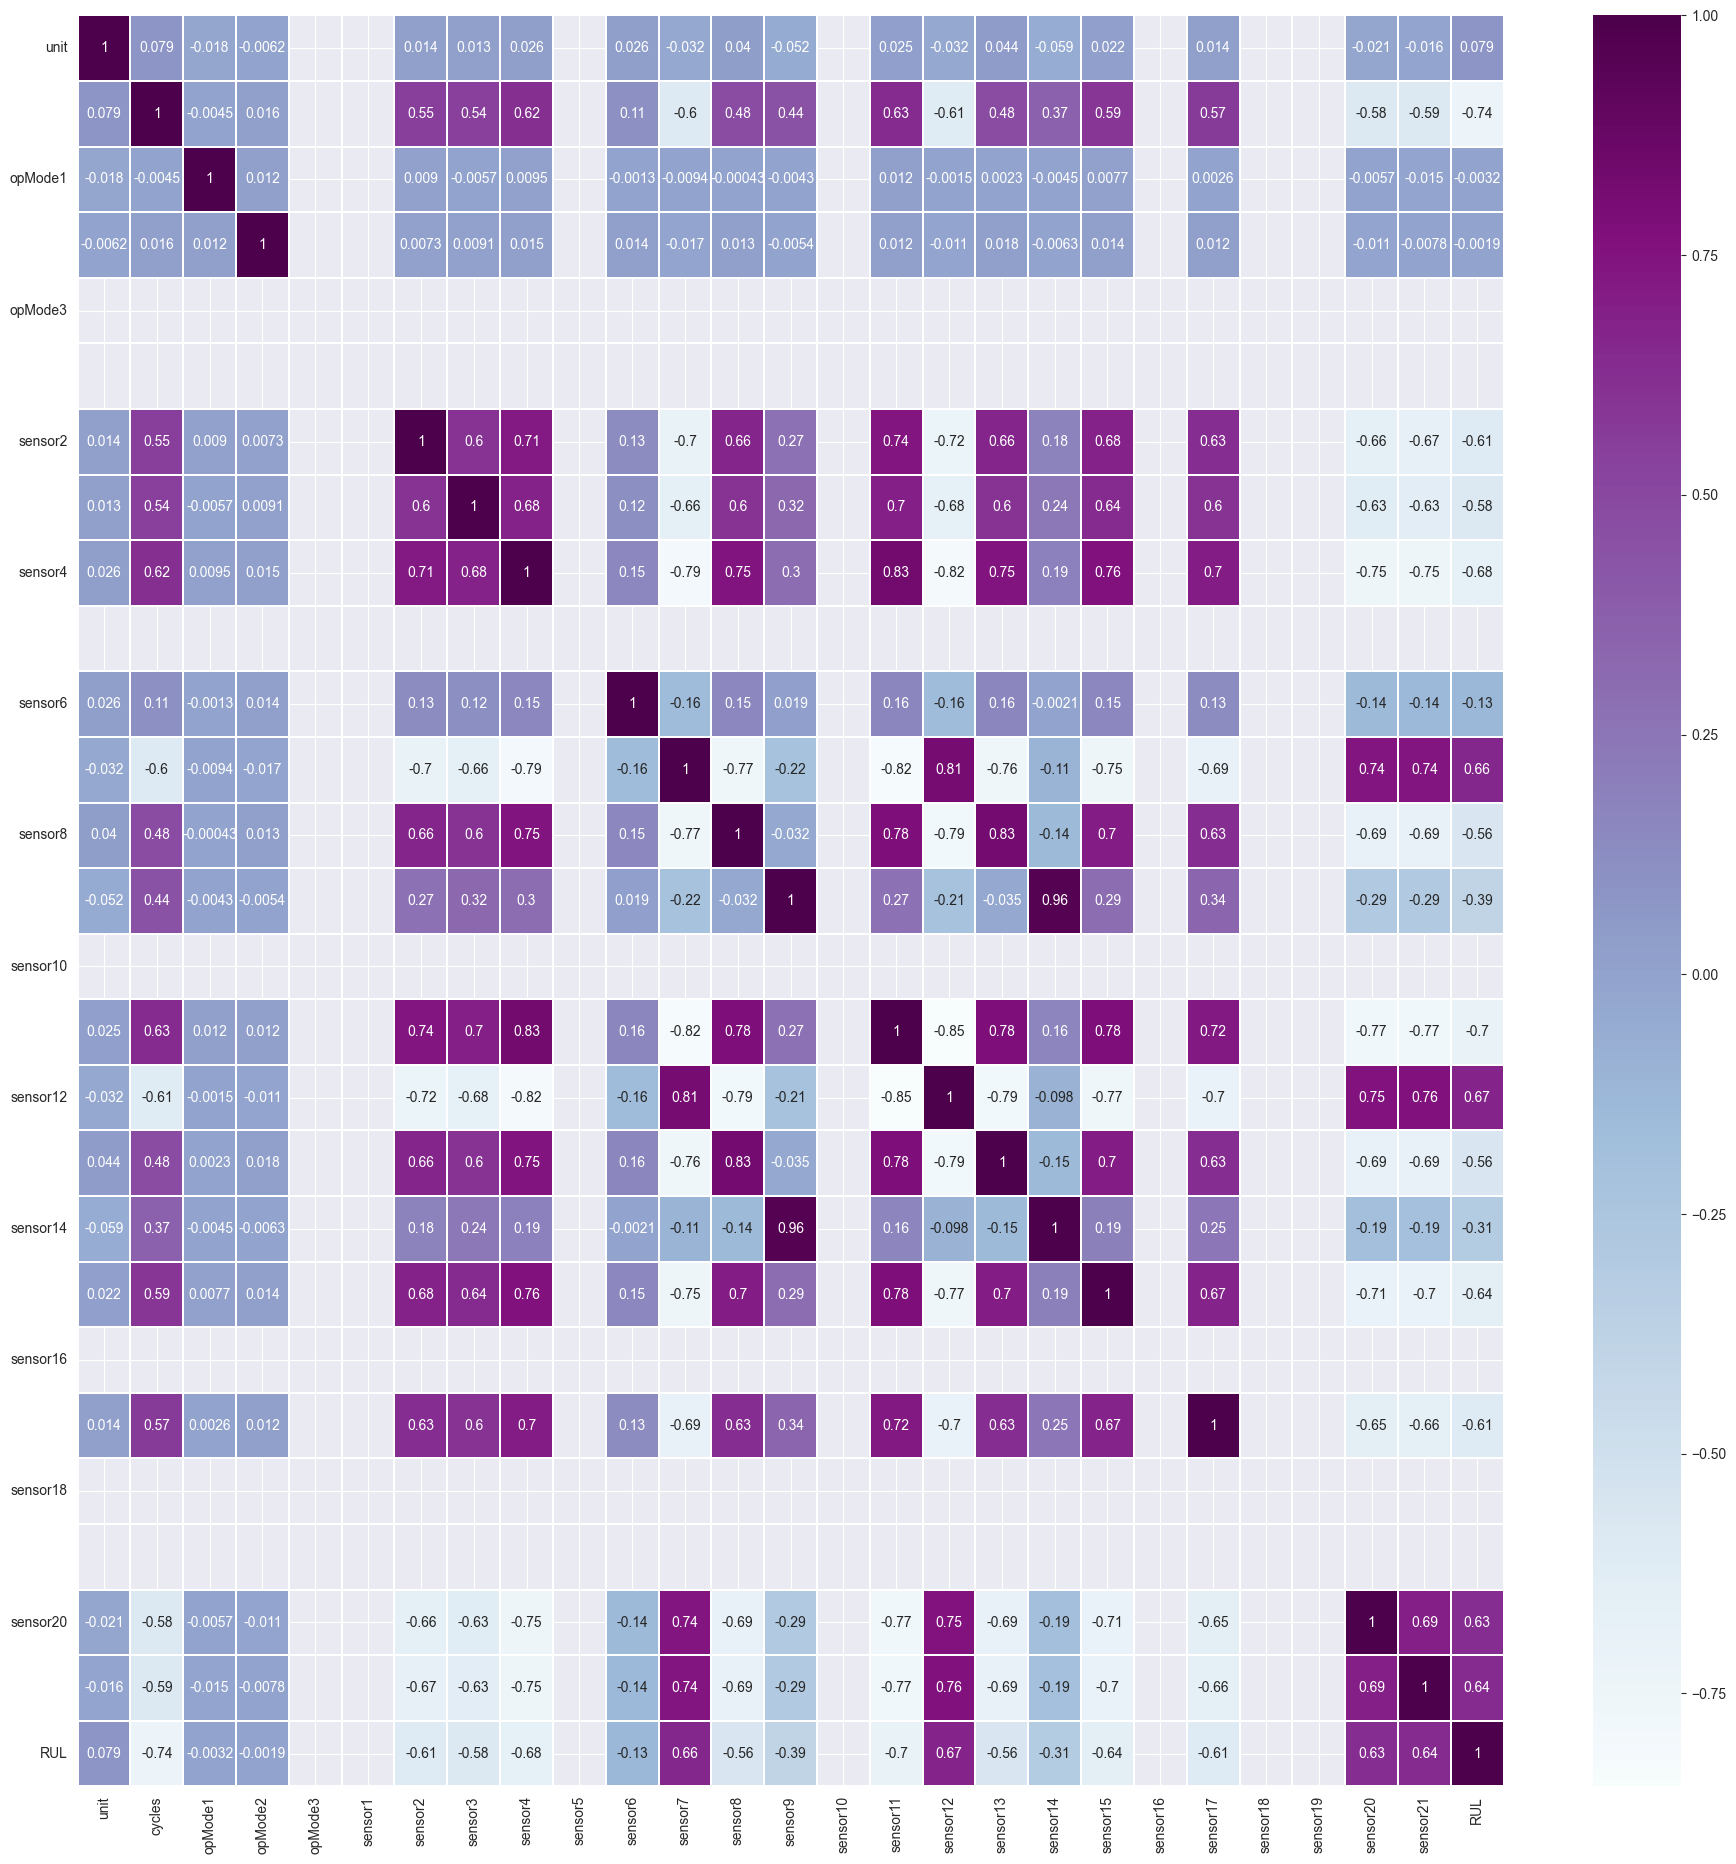

In [8]:
sns.heatmap(train_data[0].corr(), annot=True, cmap='BuPu', linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(23, 23)
plt.show()

In [9]:
"""Trajectories FD001 and FD003 both have redundant readings which can be dropped as they are constant or rarely change. FD004 and FD002 both have a redundant sensor 16."""
cols_to_drop = ['opMode3', 'sensor1', 'sensor5',
                'sensor6', 'sensor10', 'sensor16',
                'sensor18', 'sensor19', 'sensor17']

train_data[0].drop(columns=cols_to_drop, inplace=True)
train_data[2].drop(columns=cols_to_drop, inplace=True)
test_data[0].drop(columns=cols_to_drop, inplace=True)
test_data[2].drop(columns=cols_to_drop, inplace=True)

train_data[1].drop(columns=['sensor16'], inplace=True)
train_data[3].drop(columns=['sensor16'], inplace=True)

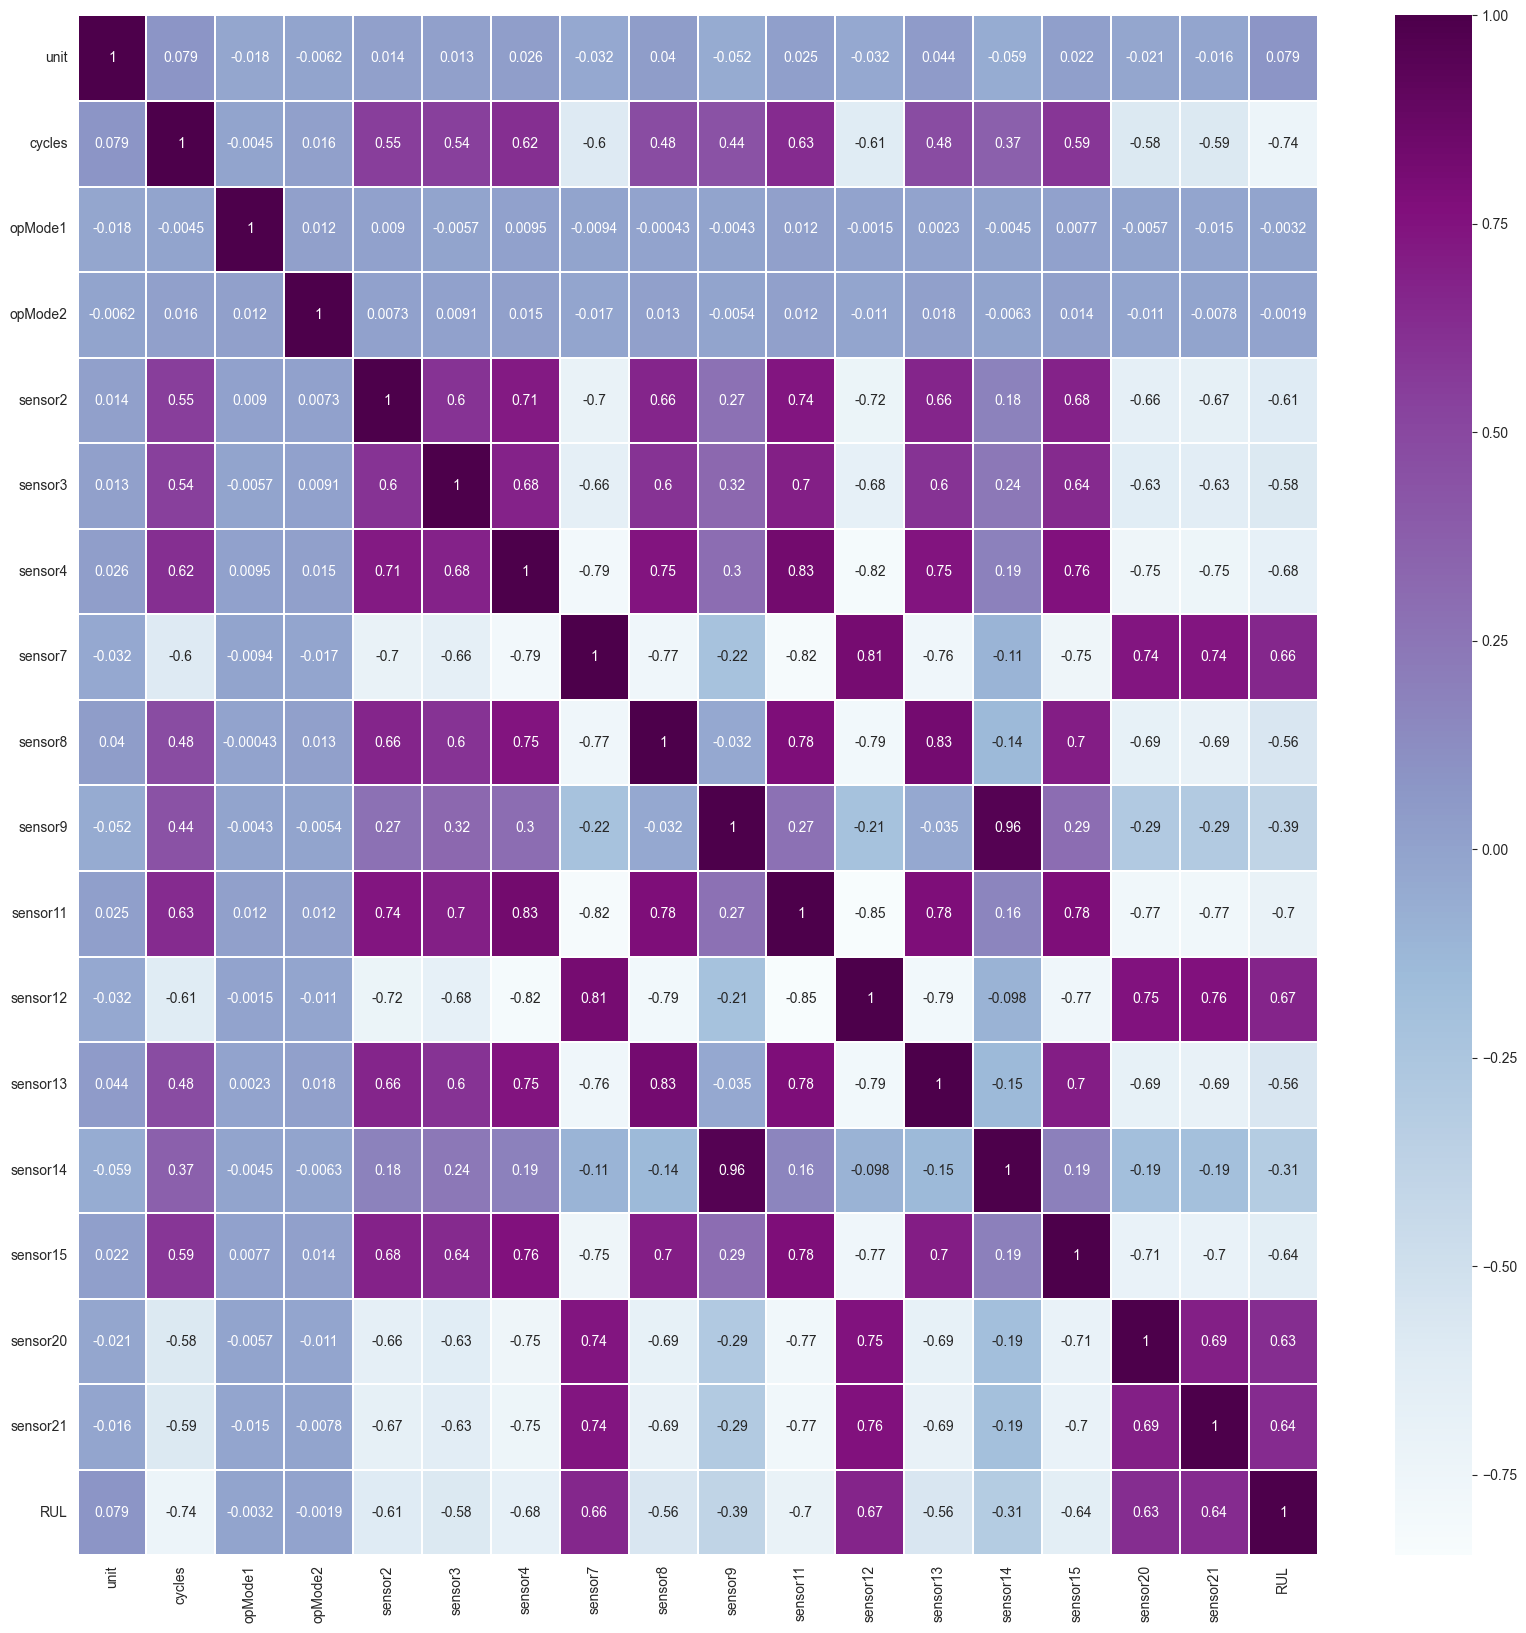

In [10]:
sns.heatmap(train_data[0].corr(), annot=True, cmap='BuPu', linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.show()

In [11]:
# Removing properties with weak correlation and high inter-correlation
# sensor 14 and has aa very high correlation with sensor 9, we can remove sensor 14 to reduce multicollinearity
train_data[0].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
test_data[0].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
train_data[2].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
test_data[2].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)

In [12]:
# Min-max scaling the data, except [cycles, RUL]
scaler = MinMaxScaler(feature_range=(-1, 1))

train_data[0].iloc[:, 2:-1] = scaler.fit_transform(train_data[0].iloc[:, 2:-1])
test_data[0].iloc[:, 2:] = scaler.transform(test_data[0].iloc[:, 2:])

train_data[2].iloc[:, 2:-1] = scaler.fit_transform(train_data[2].iloc[:, 2:-1])
test_data[2].iloc[:, 2:] = scaler.transform(test_data[2].iloc[:, 2:])

In [13]:
# Creating a training sequence
def create_training_sequence(df, seq_length, seq_cols):
    
    """function to prepare training data into (samples, time steps, features)
    df = training dataframe
    seq_length = look-back period
    seq_cols = feature columns"""

    data_array = df[seq_cols].values
    num_elements = data_array.shape[0]
    # issue is on line 74; num_elements is 1 and the for loop on line 80 has no effect because seq_length > num_elements

    lstm_array = []

    for start, stop in zip(range(0, num_elements - seq_length + 1), range(seq_length, num_elements + 1)):
        lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)

def create_target_sequence(df, seq_length, label):
    data_array = df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length - 1:num_elements + 1]


def create_training_batch(df, seq_length, columns):
    """Since the test data is stopped some arbitrary time before failure,
       the number of engine cycles won't necessarily be longer than a given window length,
       so we generate testing sequences which meet the sequence_length 
       """
    x = np.concatenate(
        list(list(create_training_sequence(df[df['unit'] == i], seq_length, columns)) for i in df['unit'].unique()))
    y = np.concatenate(
        list(list(create_target_sequence(df[df['unit'] == i], seq_length, 'RUL')) for i in df['unit'].unique()))
    return x, y


In [14]:
FD_columns = [[column for column in df if column != 'RUL'] for df in train_data]

In [15]:
sequence_length = 15
trajectory = 0  # see readme file
batch_size = 64
FD001_train = train_data[trajectory]
FD001_test = test_data[trajectory]
FD001_truth = RUL_data[trajectory]

In [16]:
a, b = create_training_batch(FD001_train, sequence_length, FD_columns[trajectory])

In [17]:
feature_count = a.shape[2]
out_dim = 1  # output dimension (1 RUL value)
a.shape  # (rows, sequence length, feature count)


(19231, 15, 14)

In [18]:
x_train, x_val, y_train, y_val = train_test_split(a, b, test_size=0.25, random_state=42)

train_dataset = TensorDataset(torch.tensor(x_train).float(),
                              torch.tensor(y_train).float().unsqueeze(1))
val_dataset = TensorDataset(torch.tensor(x_val).float(),
                            torch.tensor(y_val).float().unsqueeze(1))

In [19]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [20]:
# Using the ground truth labels to create an RUL column in the test data
rul = pd.DataFrame(FD001_test.groupby('unit')['cycles'].max()).reset_index()
rul.columns = ['unit', 'max']
FD001_truth.columns = ['rulTruth']
FD001_truth['unit'] = np.arange(1, len(rul) + 1, 1)  # 100 units
FD001_truth['startLife'] = rul['max'] + FD001_truth['rulTruth']  # 
FD001_truth.drop(columns=['rulTruth'], inplace=True)

In [21]:
FD001_test = FD001_test.merge(FD001_truth, on=['unit'], how='left')
FD001_test['RUL'] = FD001_test['startLife'] - FD001_test['cycles']
FD001_test.drop('startLife', axis=1, inplace=True)

# Model Creation

We use an LSTM model to capture the long-term dependencies in the time series data.

In [22]:
# Defining LSTM class
class DamagePropagationLSTM(nn.Module):
    def __init__(self, feature_count, out_dim):
        super(DamagePropagationLSTM, self).__init__()
        # Convolutional block
        #self.conv1 = nn.Conv1d(in_channels=feature_count, out_channels=128, kernel_size=3, padding=1)
        #self.maxpool1d = nn.MaxPool1d(kernel_size=3, padding=1)
        #self.flatten = nn.Flatten()
        #self.dense1 = nn.Linear(in_features=128, out_features=128)
        #self.activation1 = nn.ReLU()
        
        
        self.lstm1 = nn.LSTM(input_size=feature_count, hidden_size=64, batch_first=True, bidirectional=True)
        self.batch_norm = nn.BatchNorm1d(num_features=128)
        self.dropout1 = nn.Dropout(0.1)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(0.1)
        self.dense2 = nn.Linear(in_features=128, out_features=out_dim)
        self.activation2 = nn.LeakyReLU()

    def forward(self, x):
        #x = self.conv1(x.transpose(1, 2)).transpose(1, 2)
        #x = self.maxpool1d(x)
        #x = self.flatten(x)
        #x = self.dense1(x)
       #x = self.activation1(x)
        
        x, _ = self.lstm1(x)
        x = self.batch_norm(x.transpose(1, 2)).transpose(1, 2)
        x = self.dropout1(x)
        x, (hn, cn) = self.lstm2(x)
        x = self.dropout2(hn[-1])
        x = self.dense2(x)
        x = self.activation2(x)
        return x

In [27]:
# training function
def train_model(model, criterion, optimizer,
                train_loader, val_loader, num_epochs=60,
                patience=20, filename='unnamed_model.pt'):
    best_loss = float('inf')
    patience_counter = 0
    print("Model initialised successfully. Beginning training on {dev}...".format(dev=torch.cuda.get_device_name(0)))
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data).to(device)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * data.size(0)

        epoch_train_loss = epoch_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data).to(device)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item() * data.size(0)

        epoch_val_loss = epoch_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
        
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), filename)
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping!')
            break
    return train_losses, val_losses


def eval_model(val_loader, model, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data).to(device)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * data.size(0)
    return val_loss / len(val_loader.dataset)



In [28]:
model_filename = 'LSTM_model_kfold.pt'
#model_path = f'E:/CMAPSS/code/tft_new_2_311/{model_filename}'
model_path = f'D:/DataScience/CMAPSS/code/tft_new_311/{model_filename}'

In [26]:
epochs = 150
# K-Fold cross validation because the data is noisy
kf = KFold(n_splits=7, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(x_train)):
    print(f"Fold {fold + 1}")
    
    # Sub-DataLoaders for train and validation splits
    train_subsampler = Subset(train_dataset, train_idx)
    val_subsampler = Subset(train_dataset, val_idx)
    
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)
    
    Model = DamagePropagationLSTM(feature_count, out_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(Model.parameters(), lr=0.001, weight_decay=0.001)
    
    model1 = train_model(Model, criterion, optimizer, 
                        train_loader, val_loader, num_epochs=epochs, 
                        patience=30, filename=model_filename)
    val_loss = eval_model(val_loader, Model, criterion)
    print(f"Validation loss for fold {fold + 1}: {val_loss}")
    fold_results.append(val_loss)


Fold 1
Model initialised successfully. Beginning training on NVIDIA GeForce RTX 3070 Ti Laptop GPU...
Epoch 1/60, Training Loss: 13440.1775, Validation Loss: 12057.0341
Epoch 2/60, Training Loss: 11544.1482, Validation Loss: 10834.5368
Epoch 3/60, Training Loss: 10605.0536, Validation Loss: 10004.1476
Epoch 4/60, Training Loss: 9833.0636, Validation Loss: 9277.0068
Epoch 5/60, Training Loss: 9144.2647, Validation Loss: 8614.6571
Epoch 6/60, Training Loss: 8499.8304, Validation Loss: 7980.4816
Epoch 7/60, Training Loss: 7896.5728, Validation Loss: 7401.1656
Epoch 8/60, Training Loss: 7342.1043, Validation Loss: 6863.2687
Epoch 9/60, Training Loss: 6833.3797, Validation Loss: 6375.6028
Epoch 10/60, Training Loss: 6360.4234, Validation Loss: 5931.1628
Epoch 11/60, Training Loss: 5929.6333, Validation Loss: 5509.6598
Epoch 12/60, Training Loss: 5535.8176, Validation Loss: 5119.1994
Epoch 13/60, Training Loss: 5169.6137, Validation Loss: 4766.4562
Epoch 14/60, Training Loss: 4821.9885, Vali

RuntimeError: Input and parameter tensors are not at the same device, found input tensor at cpu and parameter tensor at cuda:0

# Model performance

In [ ]:
# K-Fold results
avg_val_loss = np.mean(fold_results)
print(f"Average validation loss across folds: {avg_val_loss}")

In [127]:
ModelTest = DamagePropagationLSTM(feature_count, out_dim).to(device)
ModelTest.load_state_dict(torch.load(model_path))
ModelTest.eval()

DamagePropagationLSTM(
  (lstm1): LSTM(14, 64, batch_first=True, bidirectional=True)
  (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (lstm2): LSTM(128, 256, batch_first=True, bidirectional=True)
  (dropout2): Dropout(p=0.15, inplace=False)
  (dense2): Linear(in_features=256, out_features=1, bias=True)
  (activation2): LeakyReLU(negative_slope=0.01)
)

In [128]:
# expects a tuple of training and validation losses from line 195
def loss_graphs(model):
    e = range(1, len(model[0]) + 1)  # the lists in the tuple are of equal length, can be model[1]
    plt.figure(figsize=(10,5))
    plt.plot(e, model[0], 'b', label='Training loss')
    plt.plot(e, model[1], 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()

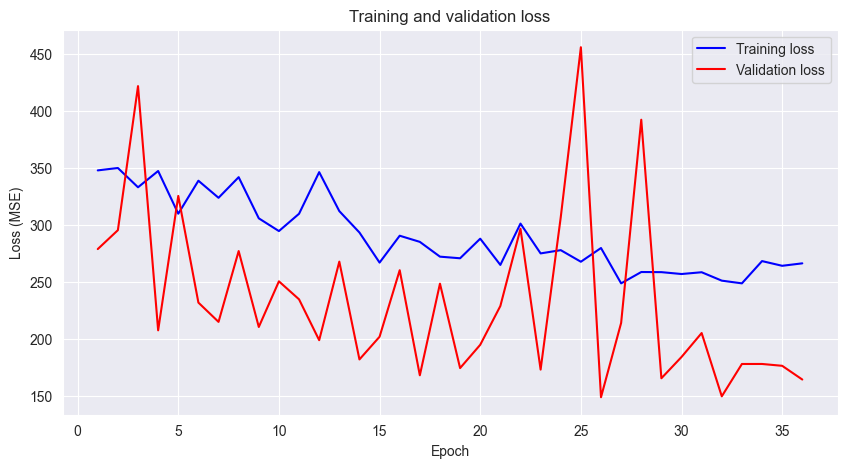

In [129]:
loss_graphs(model1)

In [131]:
# Preparing data for training evaluation
x_train_tensor = torch.tensor(x_train).float().to(device)

with torch.no_grad():
    y_train_pred = ModelTest(x_train_tensor)
    
y_train_pred = y_train_pred.cpu().numpy()
y_train_tensor = torch.tensor(y_train).float().unsqueeze(1).cpu().numpy()

### Model evaluation on validation data

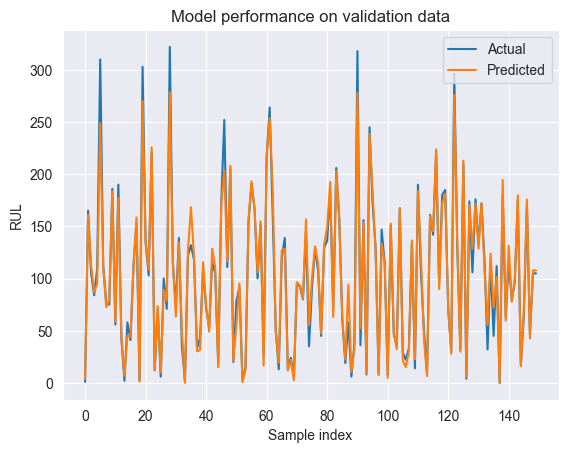

In [132]:
plt.plot(y_train[0:150], label='Actual')
plt.plot(y_train_pred[0:150], label='Predicted')
plt.title('Model performance on validation data')
plt.xlabel('Sample index')
plt.ylabel('RUL')
plt.legend()
plt.show()

# Preparing test data

In [88]:
test_cols = list(FD001_test.columns[:-1])
x_test = create_training_sequence(FD001_test, sequence_length, test_cols)
x_test_tensor = torch.tensor(x_test).float().to(device)



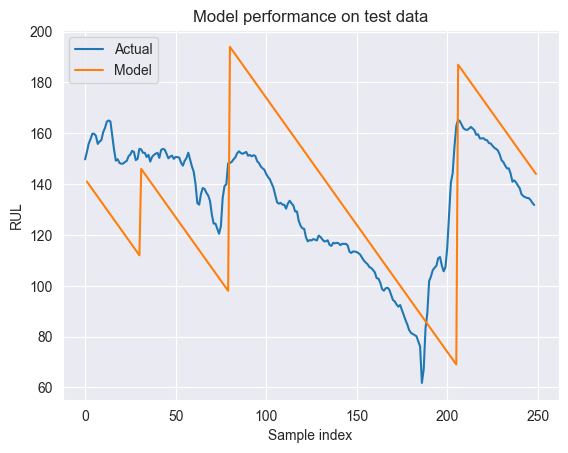

In [133]:
ModelTest.eval()
with torch.no_grad():
    y_test_pred = ModelTest(x_test_tensor)
    
y_test_pred = torch.Tensor.cpu(y_test_pred)

plt.plot(y_test_pred[1:250], label='Actual')
plt.plot(FD001_test['RUL'][1:250], label='Model')
plt.xlabel('Sample index')
plt.ylabel('RUL')
plt.title("Model performance on test data")
plt.legend()
plt.show()

In [ ]:
# Score evaluation

Exploring the uses of dropout layers in recurrent architectures and how to optimise them.
[1] https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7333848&tag=1
Convolutional layer adjustment
[2] https://arxiv.org/pdf/1603.07285v1